<a href="https://colab.research.google.com/github/IevaSimonyte/Learning_AI/blob/main/%E2%80%9Efashion_ipynb%E2%80%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -Uqq kaggle
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 16.9MB/s 
     |████████████████████████████████| 194kB 58.2MB/s 
     |████████████████████████████████| 1.2MB 49.8MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 61kB 10.9MB/s 


In [4]:
from fastbook import *
from fastai.vision.widgets import *
import pandas as pd, os, json

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Training on fashion dataset

In [7]:
api_token = {"username":"ievasim","key":"fab97f3afe1095d95dbc4ce9c503dbd6"}

!mkdir .kaggle

with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 /content/.kaggle/kaggle.json 
!cp /content/.kaggle/kaggle.json ~/.kaggle/
!mkdir /fashion
!kaggle datasets download -d paramaggarwal/fashion-product-images-small -p /fashion/
!unzip -q /fashion/fashion-product-images-small.zip -d /fashion

mkdir: cannot create directory ‘.kaggle’: File exists
mkdir: cannot create directory ‘/fashion’: File exists
 98% 553M/565M [00:11<00:00, 52.5MB/s]
100% 565M/565M [00:11<00:00, 52.1MB/s]


In [8]:
df = pd.read_csv('/fashion/myntradataset/styles.csv',  error_bad_lines=False)
df.head(3)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch


In [9]:
df.masterCategory.describe()

count       44424
unique          7
top       Apparel
freq        21397
Name: masterCategory, dtype: object

In [10]:
df.masterCategory.value_counts()

Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [11]:
to_omit = ['Free Items', 'Sporting Goods', 'Home']
df = df[~df.masterCategory.str.contains('|'.join(to_omit))]
df.masterCategory.value_counts()

Apparel          21397
Accessories      11274
Footwear          9219
Personal Care     2403
Name: masterCategory, dtype: int64

In [12]:
path = "/fashion/myntradataset/"

In [13]:
df.id = ["{}.jpg".format(i) for i in df.id]
df.head(1)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970.jpg,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt


In [14]:
broken_img = ['39401.jpg', '12347.jpg', '39425.jpg', '39403.jpg', '39410.jpg']
df = df[~df.id.str.contains('|'.join(broken_img))]
df.head(1)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970.jpg,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt


In [87]:
transf = Resize(128)
#transf = Resize(128, ResizeMethod.Squish)
#transf = Resize(128, ResizeMethod.Pad, pad_mode='zeros')
#transf = RandomResizedCrop(128, min_scale=0.3)


dls = ImageDataLoaders.from_df(df, path=path,  fn_col=0, folder='images', \
                               label_col=2, item_tfms=transf, batch_tfms=aug_transforms(mult=2))

#dls = ImageDataLoaders.from_df(df, path=path,  fn_col=0, folder='images', \
                               #label_col=2, item_tfms=transf)

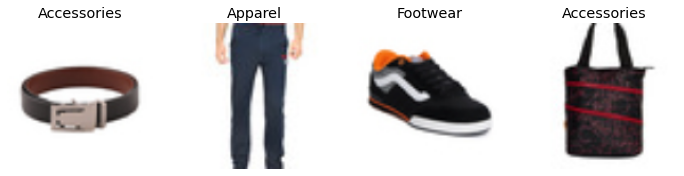

In [88]:
dls.valid.show_batch(max_n=4, nrows=1)

In [89]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.254212,0.106904,0.034888,01:29


epoch,train_loss,valid_loss,error_rate,time
0,0.104597,0.039054,0.011968,01:36
1,0.063459,0.025814,0.007452,01:36
2,0.036973,0.021442,0.006210,01:37


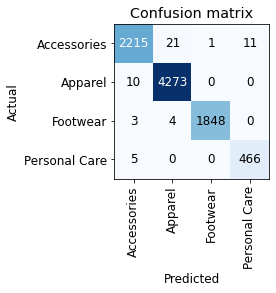

In [90]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

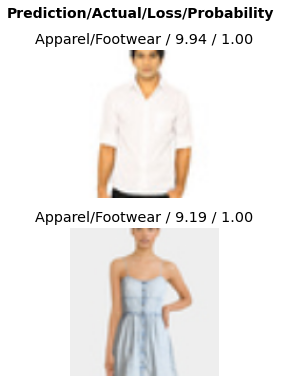

In [91]:
interp.plot_top_losses(2, nrows=2)

### Exporting model

In [92]:
 path_general = Path("/fashion")
 learn.export(path_general/'export.pkl')
 learn.save(path_general/'export')

Path('/fashion/export.pth')

### Loading saved model from .pkl file

In [96]:
learn_inf = load_learner(path_general/'export.pkl') # loading saved model
#learn_inf = load_learner('/content/export.pkl') # load model imported from drive
#learn_inf = load_model(path_general/'export.pth') # builds on top of learner

# loading model saved in dropbox
url = "https://www.dropbox.com/s/pk6z5wuvefguz0p/export.pkl?dl=1"
urllib.request.urlretrieve(url, "export.pkl")
#learn_inf = load_learner('/content/export.pkl')
learn_inf.dls.vocab

['Accessories', 'Apparel', 'Footwear', 'Personal Care']

### Deploying model with GUI

In [97]:
btn_run = widgets.Button(description='Classify')
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    #img =  PILImage(img.resize(size = (128,128)))
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(224,224))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

#hide_output
VBox([widgets.Label('Select your item!'), btn_upload, btn_run, out_pl, lbl_pred])

### Additional testing on images from internet 

In [98]:
key = os.environ.get('AZURE_SEARCH_KEY', 'f8c339de1905472699596840822969d2')

In [99]:
item_types = 'shoes','earings','dress'
path_test = Path('fashion_test')

In [100]:
if not path_test.exists():
    path_test.mkdir()
    for o in item_types:
        dest = (path_test/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, o)
        download_images(dest, urls=results.attrgot('contentUrl'))

 
Missclassified dress:
 


dress classified as Accessories with prob. of 0.87


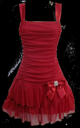

dress classified as Accessories with prob. of 0.52


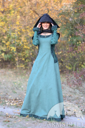

 
Missclassified earings:
 


earings classified as Apparel with prob. of 1.0


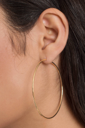

earings classified as Apparel with prob. of 1.0


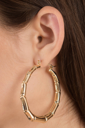

earings classified as Personal Care with prob. of 0.9


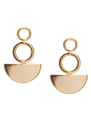

 
Missclassified shoes:
 


shoes classified as Apparel with prob. of 0.65


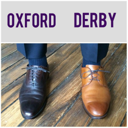

shoes classified as Accessories with prob. of 0.42


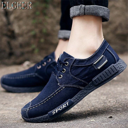

shoes classified as Accessories with prob. of 0.39


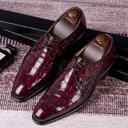

In [101]:
test_categories = ["Apparel", "Accessories", "Footwear"]
test_items = ["dress", "earings", "shoes"]
test_accuracy = {}
for j in range(len(test_categories)):
  print(" ")
  print("Missclassified {}:".format(test_items[j]))
  print(" ")
  broken_img=0
  false_pred=0
  nr_files = 0
  item_dir = Path(path_test/test_items[j])
  for i in os.listdir(item_dir):
    imgdir = Path(item_dir)/Path(i)
    if verify_image(imgdir) is True:
        nr_files+=1
        pred,pred_idx,probs = learn_inf.predict(imgdir)
        if pred != test_categories[j] :
            false_pred+=1
            if false_pred < 4:
              print(test_items[j], "classified as", pred, "with prob. of", round(float(probs.max()),2))
              img = PILImage.create(imgdir)
              display(img.to_thumb(128,128))
    else:
          pass
    test_accuracy[test_items[j]] = 1 - false_pred / (nr_files)

In [102]:
test_accuracy

{'dress': 0.9863945578231292,
 'earings': 0.7916666666666666,
 'shoes': 0.7913669064748201}